In [1]:
import pandas as pd
import re
import warnings
warnings.filterwarnings('ignore')

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
#from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


from joblib import dump, load

In [66]:
import nltk as nltk
import nltk.corpus 
from nltk.corpus import stopwords
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [30]:
import multiprocessing
from pandarallel import pandarallel


num_processors = multiprocessing.cpu_count()
workers = num_processors-1
print(f'Available CPUs: {num_processors}')

Available CPUs: 8


In [31]:
pandarallel.initialize(nb_workers=num_processors-1, use_memory_fs=False)

INFO: Pandarallel will run on 7 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [3]:
directory = 'https://storage.googleapis.com/msca-bdp-data-open/yelp/'
fileName = 'yelp_train_sentiment.json'

path = directory + fileName

In [4]:
%%time

df = pd.read_json(path, orient='records', lines=True)
df.shape

CPU times: user 1.69 s, sys: 915 ms, total: 2.6 s
Wall time: 4.12 s


(255717, 3)

In [5]:
df.shape

(255717, 3)

In [6]:
X = df['text']
y = df['label']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y, train_size = 0.85, test_size = 0.15)

print(f"Training records, X_train: {X_train.shape} y_train: {y_train.shape}")
print(f"Testing records, X_test: {X_test.shape} y_test: {y_test.shape}")

Training records, X_train: (217359,) y_train: (217359,)
Testing records, X_test: (38358,) y_test: (38358,)


# Train Classifier
### SVM(Support Vector Machine）

In [8]:
pipe_svm = make_pipeline(
    TfidfVectorizer(lowercase=False, stop_words='english', ngram_range=(1,3)),
    SGDClassifier(max_iter=100, tol=None)
)

In [9]:
pipe_svm.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(lowercase=False, ngram_range=(1, 3),
                                 stop_words='english')),
                ('sgdclassifier', SGDClassifier(max_iter=100, tol=None))])

In [10]:
y_pred_svm = pipe_svm.predict(X_test)

In [11]:
# calculate precision and recall
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96     19199
           1       0.97      0.95      0.96     19159

    accuracy                           0.96     38358
   macro avg       0.96      0.96      0.96     38358
weighted avg       0.96      0.96      0.96     38358



### Logistic Regression

In [12]:
pipe_logreg = make_pipeline(
    TfidfVectorizer(lowercase=False, stop_words='english', ngram_range=(1,3)),
    LogisticRegression(max_iter=1000)
)

In [13]:
pipe_logreg.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(lowercase=False, ngram_range=(1, 3),
                                 stop_words='english')),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [14]:
y_pred_logreg = pipe_logreg.predict(X_test)

In [15]:
print(classification_report(y_test, y_pred_logreg))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97     19199
           1       0.97      0.96      0.97     19159

    accuracy                           0.97     38358
   macro avg       0.97      0.97      0.97     38358
weighted avg       0.97      0.97      0.97     38358



## Naive Bayes 

In [19]:
pipe_nb = make_pipeline(
    CountVectorizer(lowercase=False, stop_words='english', ngram_range=(1,3)),
    MultinomialNB()
)

In [20]:
%time pipe_nb.fit(X_train, y_train);

CPU times: user 2min 29s, sys: 4.12 s, total: 2min 33s
Wall time: 2min 33s


Pipeline(steps=[('countvectorizer',
                 CountVectorizer(lowercase=False, ngram_range=(1, 3),
                                 stop_words='english')),
                ('multinomialnb', MultinomialNB())])

In [21]:
%time y_pred = pipe_nb.predict(X_test)

CPU times: user 9.13 s, sys: 89.3 ms, total: 9.22 s
Wall time: 9.21 s


In [22]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.98      0.95     19199
           1       0.98      0.92      0.95     19159

    accuracy                           0.95     38358
   macro avg       0.95      0.95      0.95     38358
weighted avg       0.95      0.95      0.95     38358



#### Logistic Regression has a higher accuracy and f1 score. Thus, I will apply logistic regression model to predict sentiment on the new data.

In [23]:
%time dump(pipe_svm, "svm.joblib")

CPU times: user 2min 16s, sys: 3.72 s, total: 2min 19s
Wall time: 2min 19s


['svm.joblib']

In [24]:
%time dump(pipe_logreg, "logreg.joblib")

CPU times: user 2min 16s, sys: 3.92 s, total: 2min 20s
Wall time: 2min 19s


['logreg.joblib']

In [25]:
%time dump(pipe_nb, "nb.joblib")

CPU times: user 2min 17s, sys: 5.24 s, total: 2min 22s
Wall time: 2min 22s


['nb.joblib']

## News article data 

In [32]:
%%time

df_new = pd.read_parquet('nlp_clean_text.parquet')
df_new.shape

CPU times: user 4.38 s, sys: 3.08 s, total: 7.46 s
Wall time: 8.2 s


(184488, 3)

In [33]:
test = df_new['clean_title']
y_pred = pipe_logreg.predict(test)

In [34]:
df_new["sentiment"] = y_pred

In [35]:
df_new['sentiment_category'] = df_new['sentiment'].map({0: 'Negative', 1: 'Positive'})

In [36]:
df_new.head()

,date,clean_title,clean_text,sentiment,sentiment_category
0,2020-01-28,auckland.scoop.co.nz » AUT boosts AI expertise...,auckland.scoop.co.nz » AUT boosts AI expertise...,1,Positive
1,2021-03-18,Artificial intelligence improves parking effic...,Artificial intelligence improves parking effic...,1,Positive
2,2020-02-26,LegalTech Artificial Intelligence Market 2019 ...,LegalTech Artificial Intelligence Market 2019 ...,0,Negative
3,2020-02-27,Children With Autism Saw Their Learning and So...,Children With Autism Saw Their Learning and So...,0,Negative
4,2021-07-05,"Observation, Simulation, And AI Join Forces To...","Observation, Simulation, And AI Join Forces To...",0,Negative


In [55]:
min_date = df_new['date'].min()
max_date = df_new['date'].max()

print('Data ranges from {} to {}'.format(min_date, max_date))

Data ranges from 2020-01-01 to 2023-02-07


In [37]:
# count of articles by sentiment category and date
df_sen_time = pd.DataFrame(df_new.groupby(["date", "sentiment_category"]).count()["sentiment"]).rename(columns = {"sentiment":"count_of_articles"}).reset_index()
df_sen_time.head(2)

,date,sentiment_category,count_of_articles
0,2020-01-01,Negative,32
1,2020-01-01,Positive,14


In [56]:
min_date = df_sen_time['date'].min()
max_date = df_sen_time['date'].max()

print('Data ranges from {} to {}'.format(min_date, max_date))

Data ranges from 2020-01-01 to 2023-02-07


In [38]:
df_pos = df_new[df_new["sentiment_category"]=="Positive"][["date", "clean_title", "clean_text", "sentiment", "sentiment_category"]]
df_pos.head(1)

,date,clean_title,clean_text,sentiment,sentiment_category
0,2020-01-28,auckland.scoop.co.nz » AUT boosts AI expertise...,auckland.scoop.co.nz » AUT boosts AI expertise...,1,Positive


In [57]:
min_date = df_pos['date'].min()
max_date = df_pos['date'].max()

print('Data ranges from {} to {}'.format(min_date, max_date))

Data ranges from 2020-01-01 to 2023-02-07


In [85]:
df_pos["date"] = pd.to_datetime(df_pos["date"])

In [70]:
df_neg= df_new[df_new["sentiment_category"]=="Negative"][["date", "clean_title", "clean_text", "sentiment", "sentiment_category"]]
df_neg.head(1)

,date,clean_title,clean_text,sentiment,sentiment_category
2,2020-02-26,LegalTech Artificial Intelligence Market 2019 ...,LegalTech Artificial Intelligence Market 2019 ...,0,Negative


In [83]:
df_neg["date"] = pd.to_datetime(df_neg["date"])

In [84]:
df_neg[df_neg["date"] == "2023-02-07"]

,date,clean_title,clean_text,sentiment,sentiment_category
59,2023-02-07,"Jerry Seinfeld on AI Seinfeld: ""You Gotta Be ...","Jerry Seinfeld on AI Seinfeld: ""You Gotta Be D...",0,Negative
122,2023-02-07,Microsoft revamps Bing search engine to use ar...,Microsoft revamps Bing search engine to use ar...,0,Negative
374,2023-02-07,"Google hopes ''Bard'' will outsmart ChatGPT, M...","Google hopes ''Bard'' will outsmart ChatGPT, M...",0,Negative
436,2023-02-07,Artificial Intelligence Opens The Door To More...,Artificial Intelligence Opens The Door To More...,0,Negative
886,2023-02-07,"Google hopes ‘Bard’ will outsmart ChatGPT, Mic...","Google hopes ‘Bard’ will outsmart ChatGPT, Mi...",0,Negative
...,...,...,...,...,...
183388,2023-02-07,"Google hopes ‘Bard’ will outsmart ChatGPT, Mic...","Google hopes ‘Bard’ will outsmart ChatGPT, Mic...",0,Negative
183501,2023-02-07,"Review: Digital tech advances, AI spur hacking...","Review: Digital tech advances, AI spur hacking...",0,Negative
183697,2023-02-07,"google ai: LaMDA powered Bard, Google's answer...","google ai: LaMDA powered Bard, Google's answer...",0,Negative
183752,2023-02-07,"Review: Digital tech advances, AI spur hacking...","Review: Digital tech advances, AI spur hacking...",0,Negative


In [73]:
min_date = df_neg['date'].min()
max_date = df_neg['date'].max()

print('Data ranges from {} to {}'.format(min_date, max_date))

Data ranges from 2020-01-01 to 2023-02-07


In [74]:
print(type(df_neg.date))

<class 'pandas.core.series.Series'>


In [92]:
df_new.to_csv("clean_text_sent.csv", index = False)

In [93]:
len(df_new)

184488

In [41]:
df_pos.to_csv("pos_text_custom.csv", index = False)

In [42]:
df_neg.to_csv("neg_text_custom.csv", index = False)

In [43]:
df_sent_count = pd.DataFrame({"Positive":len(df_pos), "Negative":len(df_neg)}.items(), columns=['sentiment', 'count_of_articles'])
df_sent_count

,sentiment,count_of_articles
0,Positive,61988
1,Negative,122500


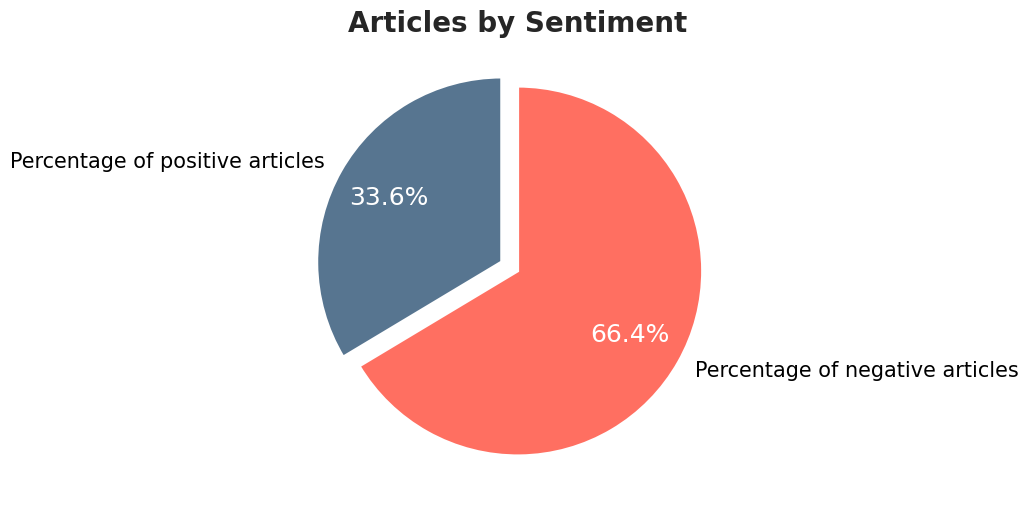

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define data
title = ['Percentage of positive articles', 'Percentage of negative articles']
val = [61988, 122500]
colors = ['#577590','#FF6F61']
explode = (0.1, 0)
total = sum(val)

# Define formatter for autopct
def my_fmt(x):
    return '{:.1f}%'.format(x)

# Create pie chart using seaborn
fig, ax = plt.subplots(figsize=(6,6))
sns.set(font_scale=1.5)
sns.set_style("whitegrid")

patches, texts, autotexts = ax.pie(val, colors=colors, labels=title, autopct=my_fmt, startangle=90, explode=explode, pctdistance=0.7, labeldistance=1.1, textprops={'fontsize': 15, 'color': 'black'}, wedgeprops={'linewidth': 2, 'edgecolor': 'white'})

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(18)

# Add title
ax.set_title('Articles by Sentiment', fontsize=20, fontweight='bold')

plt.show()

In [60]:
# count of articles with positive sentiment
df_count_pos = pd.DataFrame(df_pos.groupby(["date"]).count()["sentiment_category"]).rename(columns = {"sentiment_category":"count_of_positive_sentiment"})
df_count_pos.head(2)

,count_of_positive_sentiment
date,
2020-01-01,14
2020-01-02,52


In [61]:
print(type(df_count_pos.index))

<class 'pandas.core.indexes.base.Index'>


In [48]:
# count of articles with negative sentiment
df_count_neg = pd.DataFrame(df_neg.groupby(["date"]).count()["sentiment_category"]).rename(columns = {"sentiment_category":"count_of_negative_sentiment"})
df_count_neg.head(2)

,count_of_negative_sentiment
date,
2020-01-01,32
2020-01-02,103


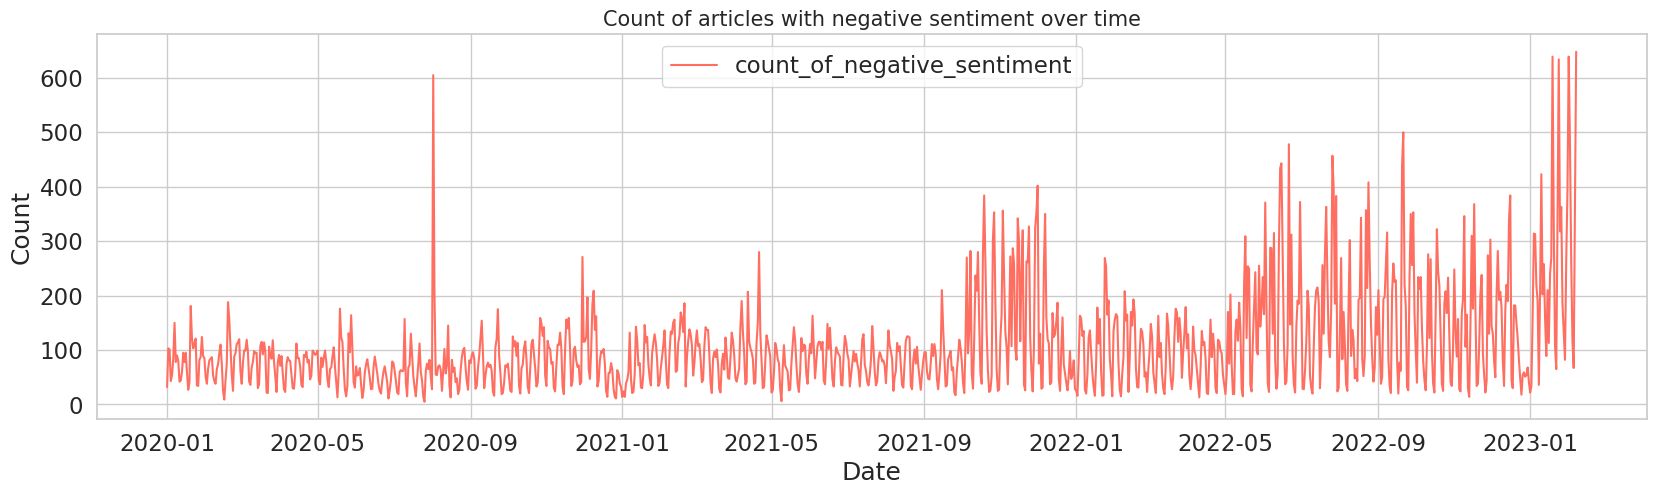

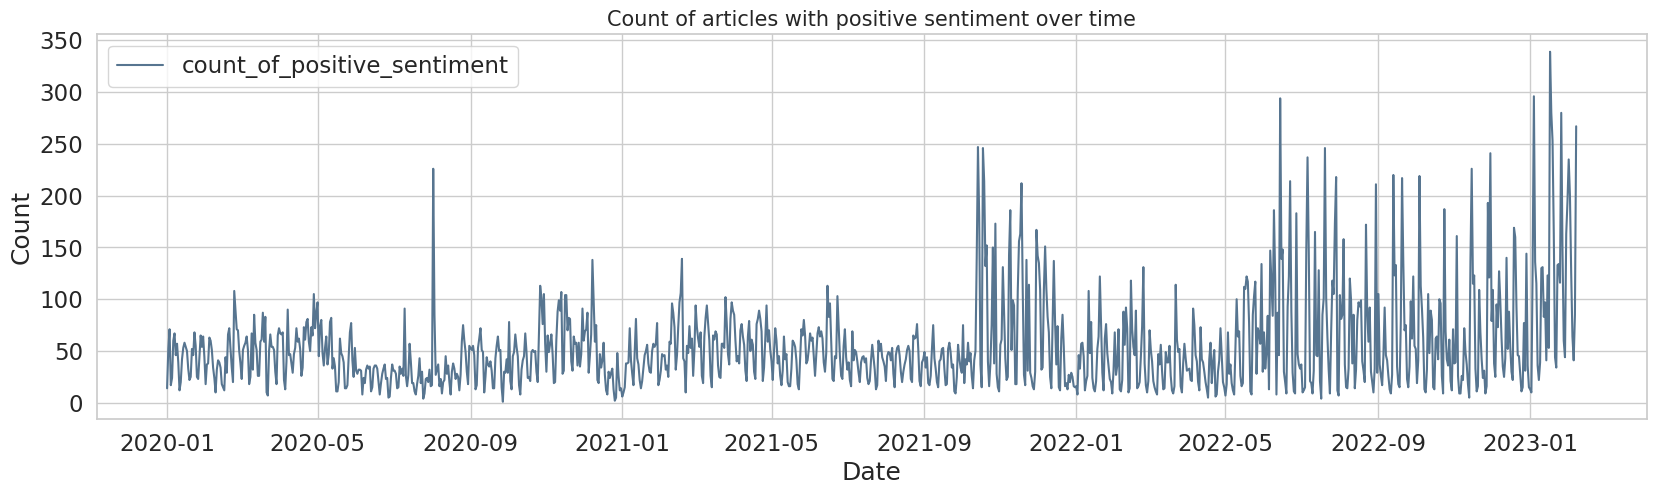

In [63]:
# Define data
plt.rcParams["figure.figsize"] = [20,5]

# Set color palette
colors = ['#FF6F61','#577590']

# Plot negative sentiment data
ax = df_count_neg.plot(color=colors[0])
ax.set_title("Count of articles with negative sentiment over time", fontsize=15)
ax.set_ylabel("Count")
ax.set_xlabel("Date")
# ax.set_xticklabels(df_count_neg.index.strftime("%Y-%m-%d"), rotation=90)

# Plot positive sentiment data
ax = df_count_pos.plot(color=colors[1])
ax.set_title("Count of articles with positive sentiment over time", fontsize=15)
ax.set_ylabel("Count")
ax.set_xlabel("Date")
# ax.set_xticklabels(df_count_pos.index.strftime("%Y-%m-%d"), rotation=90)

plt.show()

In [64]:
# positive sentiment articles : date with max count
df_count_pos.sort_values(by = "count_of_positive_sentiment", ascending= False).head()

,count_of_positive_sentiment
date,
2023-01-17,339
2023-01-04,296
2022-06-14,294
2023-01-26,280
2023-01-18,280


In [65]:
# negative sentiment articles : date with max count
df_count_neg.sort_values(by = "count_of_negative_sentiment", ascending= False).head()

,count_of_negative_sentiment
date,
2023-02-07,648
2023-02-01,639
2023-01-19,639
2023-01-24,634
2020-08-02,605


In [88]:
neg_hype = df_neg[(df_neg["date"]=="2023-02-07")|(df_neg["date"]=="2023-02-01")|(df_neg["date"]=="2023-01-19")|(df_neg["date"]=="2023-01-24")|(df_neg["date"]=="2020-08-02")][["clean_text"]]

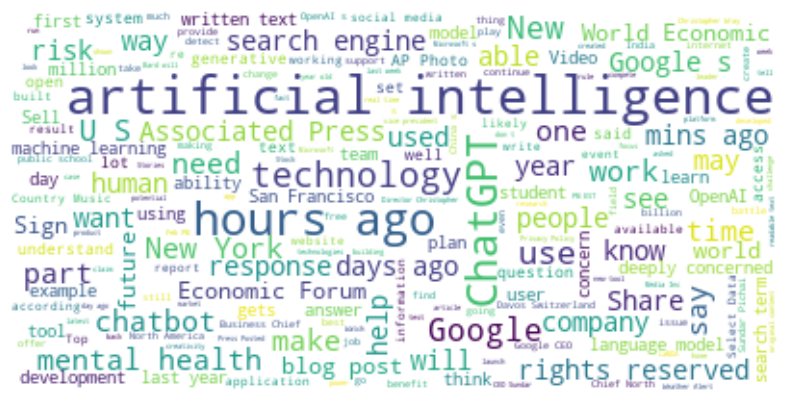

In [89]:
text = " ".join(entities for entities in neg_hype.clean_text)
# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(['Data Science', 'data science', 'DATA SCIENCE','AI', 'ai', 'artificial intelligence','Artificial Intelligence','ARTIFICIAL INTELLIGENCE', 'ML', 'NLP', 
            'Artificial General Intelligence','Chatbots', 'AI Marketplaces', 'Intelligent Applications', 
           'Augmented Intelligence', 'Decision Intelligence', 'AI Cloud Services', 'cloud services', 'GPU Accelerators', 'Computer Vision','Deep Neural Network',
           'Deep Learning','Cognitive Computing','Autonomous Vehicles','Knowledge Graphs', 'Responsible AI', 'Machine Customers', 'Decision Intelligence', 'Autonomous Vehicles',
           'Human-Centered AI', 'AI Governance', 'Natural Language Processing', 'Machine Learning', 'Smart Robots', 'Operational AI Systems' , 'Data-Centric AI', 'AI TRiSM', 'Generative AI',
           'Responsible AI'])
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize = (15,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [90]:
pos_hype = df_pos[(df_pos["date"]=="2023-01-17")|(df_pos["date"]=="2023-01-04")|(df_pos["date"]=="2022-06-14")|(df_pos["date"]=="2023-01-26")|(df_pos["date"]=="2023-01-18")][["clean_text"]]

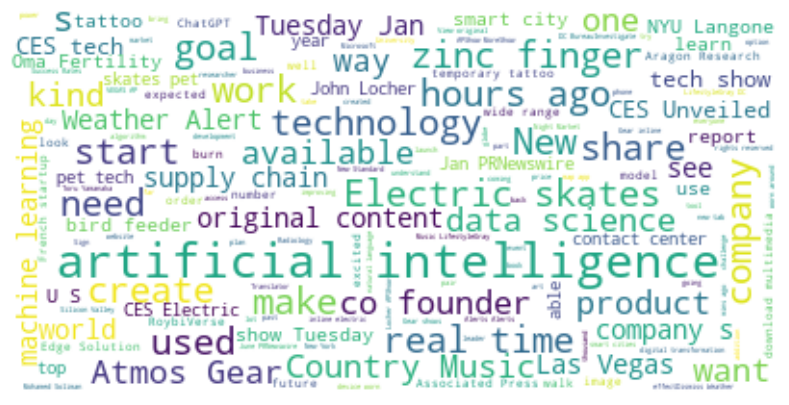

In [91]:
text = " ".join(entities for entities in pos_hype.clean_text)
# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(['Data Science', 'data science', 'DATA SCIENCE','AI', 'ai', 'artificial intelligence','Artificial Intelligence','ARTIFICIAL INTELLIGENCE', 'ML', 'NLP', 
            'Artificial General Intelligence','Chatbots', 'AI Marketplaces', 'Intelligent Applications', 
           'Augmented Intelligence', 'Decision Intelligence', 'AI Cloud Services', 'cloud services', 'GPU Accelerators', 'Computer Vision','Deep Neural Network',
           'Deep Learning','Cognitive Computing','Autonomous Vehicles','Knowledge Graphs', 'Responsible AI', 'Machine Customers', 'Decision Intelligence', 'Autonomous Vehicles',
           'Human-Centered AI', 'AI Governance', 'Natural Language Processing', 'Machine Learning', 'Smart Robots', 'Operational AI Systems' , 'Data-Centric AI', 'AI TRiSM', 'Generative AI',
           'Responsible AI'])
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize = (15,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()